In [1]:
DATA_NAME = 'agrivision-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name of the result notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name of the result notebook:
red_horizVert_wavelet_full_agrivision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
RES_DIR = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)
CWD = os.path.join(ROOT_DIR, 'anderson-darling', 'ks-ad-comparisons')
assert CWD == os.getcwd()

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')

In [4]:
os.chdir('..')
from testing_ad import *
os.chdir(os.path.join(ROOT_DIR, 'utilities'))
from testing import *
from plotting import *
os.chdir(CWD)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

In [6]:
# master_df_optimized_path = Path(os.path.join(RES_DIR, "CSVs", 'master_df_optimized.csv'))
# master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
# rEtaKsstats_dict_path = Path(os.path.join(RES_DIR, "cache", "rEtaKsstats_dict.pickle"))
# rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
# augmented_var_df_path = Path(os.path.join(RES_DIR, "CSVs", "augmented_var_df.csv"))
# augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)

Running 12760 CDFs


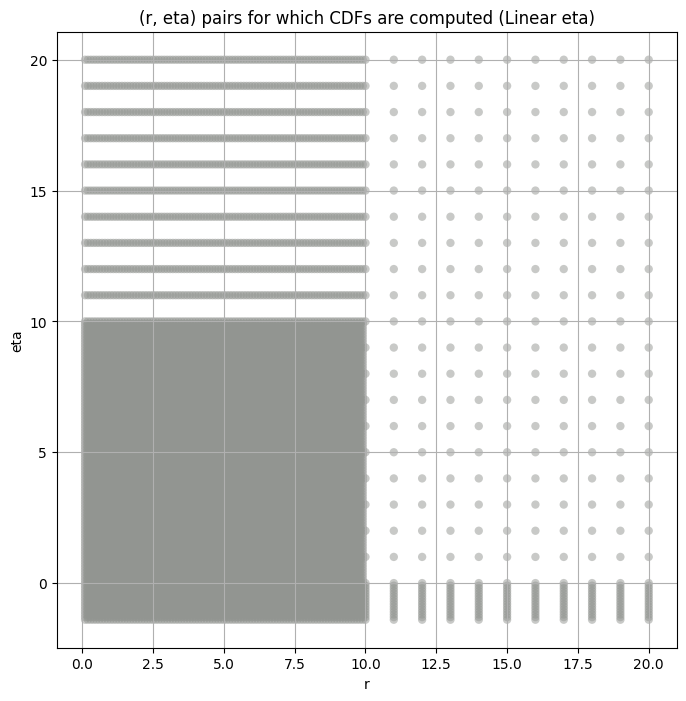

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df)
all_cdfs_df.head()

In [8]:
group = 4
sample = group_data_map[group]
size, n = len(sample), group_total_samples[group]
print(size, 'subsampled from', n)

100000 subsampled from 144000


In [9]:
# modifying implementation from testing.py
def compute_ksstat(sample, cdf, sorted_sample=True):
    '''
    Computes the KS-Test Statistic, assumes that the sample is already sorted
    '''
    if not sorted_sample:
        sample = np.sort(sample, axis=0)

    if isinstance(cdf, tuple):
        r, eta = cdf
        cdf = compute_prior_cdf(r, eta)
    
    n = sample.shape[0]
    cdfvals = cdf(sample)
    i = np.arange(1, n + 1).reshape((n,) + (1,) * (len(sample.shape) - 1)) / n
    return np.max(np.abs(cdfvals - i), axis=0)

def compute_ksstat_from_cdfvals(cdfvals):
    n = cdfvals.shape[0]
    i = np.arange(1, n + 1).reshape((n,) + (1,) * (len(cdfvals.shape) - 1)) / n
    return np.max(np.abs(cdfvals - i), axis=0)

def compute_adstat_from_cdfvals(cdfvals, true_n=None, eps=1e-16):
    cdfvals = np.clip(cdfvals, eps, 1 - eps)
    n = cdfvals.shape[0]
    i = np.arange(1, 2 * n, 2).reshape((n,) + (1,) * (len(cdfvals.shape) - 1))
    S = np.mean(i * (np.log(cdfvals) + np.log(1 - cdfvals[::-1])), axis=0)
    rescale_factor = 1 if true_n is None else true_n / n
    return rescale_factor * (-n - S)

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

augmented_vars = np.array(
    [np.var(sample[cutoff:-cutoff]) if cutoff else np.var(sample) for cutoff in EXCLUDE_CUTOFFS]
)

def cdf_stats(row, old_stats=None):
    if not (old_stats is None or (old_row := old_stats[(old_stats['r'] == row['r']) & (old_stats['eta'] == row['eta'])]).empty):
        return tuple(old_row.iloc[0][['ks_stat', 'best_scale_ks', 'best_cutoff_ks', 'ad_stat', 'best_scale_ad', 'best_cutoff_ad']])

    scales = np.clip((augmented_vars / row['variance']), 0, SCALE_CAP)
    rescaled_samples = sample[:, None] / np.sqrt(scales)

    cdfvals = row['cdf'](rescaled_samples)
    ks_stats = compute_ksstat_from_cdfvals(cdfvals)
    ad_stats = compute_adstat_from_cdfvals(cdfvals, n)
    ks_argmin, ad_argmin = ks_stats.argmin(), ad_stats.argmin()
    ks_stat, best_scale_ks, best_cutoff_ks = ks_stats[ks_argmin], scales[ks_argmin], EXCLUDE_CUTOFFS[ks_argmin]
    ad_stat, best_scale_ad, best_cutoff_ad = ad_stats[ad_argmin], scales[ad_argmin], EXCLUDE_CUTOFFS[ad_argmin]
    return ks_stat, best_scale_ks, best_cutoff_ks, ad_stat, best_scale_ad, best_cutoff_ad

stats_df = all_cdfs_df.copy()
stats_df[['ks_stat', 'best_scale_ks', 'best_cutoff_ks', 'ad_stat', 'best_scale_ad', 'best_cutoff_ad']] = \
    stats_df.apply(cdf_stats, axis=1, result_type='expand')

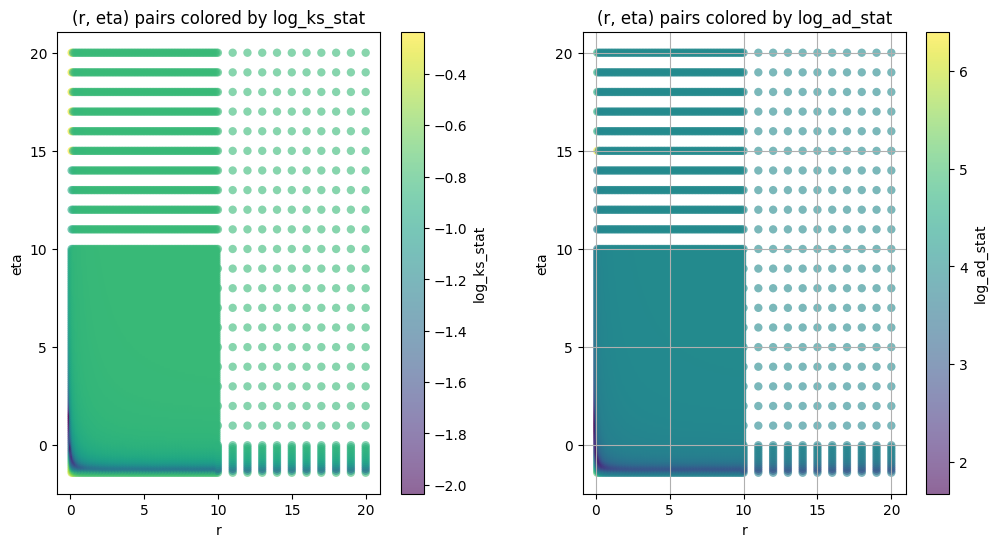

In [11]:
stats_df['log_ks_stat'] = np.log10(stats_df['ks_stat'])
stats_df['log_ad_stat'] = np.log10(stats_df['ad_stat'])
create_scatter_plots(stats_df, 'log_ks_stat', 'log_ad_stat').tight_layout()

In [12]:
alpha_ks = alpha_ad = 1e-16
ks_cutoff = stats.kstwo.isf(alpha_ks, n)
ad_cutoff = scipy.optimize.fsolve(lambda x: 1 - ad_asymptotic_cdf(x, N=15) - alpha_ad, 1)[0]

stats_df['ks_pass'] = stats_df['ks_stat'] < ks_cutoff
stats_df['ad_pass'] = stats_df['ad_stat'] < ad_cutoff
stats_df['pass_summary'] = np.select(
    [(stats_df['ks_pass']) & (stats_df['ad_pass']), stats_df['ks_pass'], stats_df['ad_pass']],
    ['Both', 'Only KS', 'Only AD'], 'Neither'
)
stats_df['pass_summary'].value_counts()

pass_summary
Neither    12755
Only KS        5
Name: count, dtype: int64

In [13]:
union = stats_df[stats_df['ks_pass'] | stats_df['ad_pass']]
min_r, min_eta = union[['r', 'eta']].min()
max_r, max_eta = union[['r', 'eta']].max()
r_pad, eta_pad = .25, 2
fine_stats_df = fine_cdfs_df[
    (fine_cdfs_df['r'] >= min_r - r_pad) &
    (fine_cdfs_df['r'] <= max_r + r_pad) &
    (fine_cdfs_df['eta'] >= min_eta - eta_pad) &
    (fine_cdfs_df['eta'] <= max_eta + eta_pad)
].copy()

print(
    'Point count relative to coarse grid:',
    fine_stats_df.shape[0] / stats_df.shape[0],
    '\nOverlap proportion with coarse grid:',
    fine_stats_df[['r', 'eta']].apply(tuple, axis=1).isin(stats_df[['r', 'eta']].apply(tuple, axis=1)).mean()
)

Point count relative to coarse grid: 0.13683385579937304 
Overlap proportion with coarse grid: 0.07731958762886598


In [14]:
fine_stats_df[['ks_stat', 'best_scale_ks', 'best_cutoff_ks', 'ad_stat', 'best_scale_ad', 'best_cutoff_ad']] = \
    fine_stats_df.apply(cdf_stats, old_stats=stats_df, axis=1, result_type='expand')
fine_stats_df['ks_pass'] = fine_stats_df['ks_stat'] < ks_cutoff
fine_stats_df['ad_pass'] = fine_stats_df['ad_stat'] < ad_cutoff
fine_stats_df['pass_summary'] = np.select(
    [(fine_stats_df['ks_pass']) & (fine_stats_df['ad_pass']), fine_stats_df['ks_pass'], fine_stats_df['ad_pass']],
    ['Both', 'Only KS', 'Only AD'], 'Neither'
)
fine_stats_df['pass_summary'].value_counts()

pass_summary
Neither    1677
Only KS      69
Name: count, dtype: int64

In [15]:
ks_argmin_row = fine_stats_df.iloc[fine_stats_df['ks_stat'].argmin()]
best_ks_ad_stat = compute_adstat(sample / np.sqrt(ks_argmin_row['best_scale_ks']), ks_argmin_row['cdf'])
print(
    f"Best params for KS: (r, eta, scale) = {tuple(ks_argmin_row[['r', 'eta', 'best_scale_ks']])}",
    f"KS stat = {ks_argmin_row['ks_stat']:.6f}, p-value = {stats.kstwo.sf(ks_argmin_row['ks_stat'], n):e} *",
    f"AD stat = {best_ks_ad_stat:.6f}, p-value = {1 - ad_asymptotic_cdf(best_ks_ad_stat, N=15):e}",
    sep='\n', end='\n\n'
)
ad_argmin_row = fine_stats_df.iloc[fine_stats_df['ad_stat'].argmin()]
best_ad_ks_stat = compute_ksstat(sample / np.sqrt(ad_argmin_row['best_scale_ad']), ad_argmin_row['cdf'])
print(
    f"Best params for AD: (r, eta, scale) = {tuple(ad_argmin_row[['r', 'eta', 'best_scale_ad']])}",
    f"KS stat = {best_ad_ks_stat:.6f}, p-value = {stats.kstwo.sf(best_ad_ks_stat, n):e}",
    f"AD stat = {ad_argmin_row['ad_stat']:.6f}, p-value = {1 - ad_asymptotic_cdf(ad_argmin_row['ad_stat'], N=15):e} *",
    sep='\n'
)

Best params for KS: (r, eta, scale) = (0.08, 2.0, 1.5687110153744052e-18)
KS stat = 0.007877, p-value = 3.447354e-08 *
AD stat = 39.136288, p-value = 1.221245e-15

Best params for AD: (r, eta, scale) = (0.06, 2.6, 1.2631685800512492e-28)
KS stat = 0.013137, p-value = 5.148393e-22
AD stat = 38.897310, p-value = 2.220446e-16 *


In [16]:
ks_argmin_row = fine_stats_df.iloc[fine_stats_df['ks_stat'].argmin()]
best_ks_ad_stat = compute_adstat(sample / np.sqrt(ks_argmin_row['best_scale_ks']), ks_argmin_row['cdf'], n)
print(
    f"Best params for KS: (r, eta, scale) = {tuple(ks_argmin_row[['r', 'eta', 'best_scale_ks']])}",
    f"KS stat = {ks_argmin_row['ks_stat']:.6f}, p-value = {stats.kstwo.sf(ks_argmin_row['ks_stat'], n):e} *",
    f"AD stat = {best_ks_ad_stat:.6f}, p-value = {1 - ad_asymptotic_cdf(best_ks_ad_stat, N=10):e}",
    sep='\n', end='\n\n'
)
ad_argmin_row = fine_stats_df.iloc[fine_stats_df['ad_stat'].argmin()]
best_ad_ks_stat = compute_ksstat(sample / np.sqrt(ad_argmin_row['best_scale_ad']), ad_argmin_row['cdf'])
print(
    f"Best params for AD: (r, eta, scale) = {tuple(ad_argmin_row[['r', 'eta', 'best_scale_ad']])}",
    f"KS stat = {best_ad_ks_stat:.6f}, p-value = {stats.kstwo.sf(best_ad_ks_stat, n):e}",
    f"AD stat = {ad_argmin_row['ad_stat']:.6f}, p-value = {1 - ad_asymptotic_cdf(ad_argmin_row['ad_stat'], N=10):e} *",
    sep='\n'
)

Best params for KS: (r, eta, scale) = (0.08, 2.0, 1.5687110153744052e-18)
KS stat = 0.007877, p-value = 3.447354e-08 *
AD stat = 56.356255, p-value = 5.281220e-12

Best params for AD: (r, eta, scale) = (0.06, 2.6, 1.2631685800512492e-28)
KS stat = 0.013137, p-value = 5.148393e-22
AD stat = 38.897310, p-value = 2.220446e-16 *


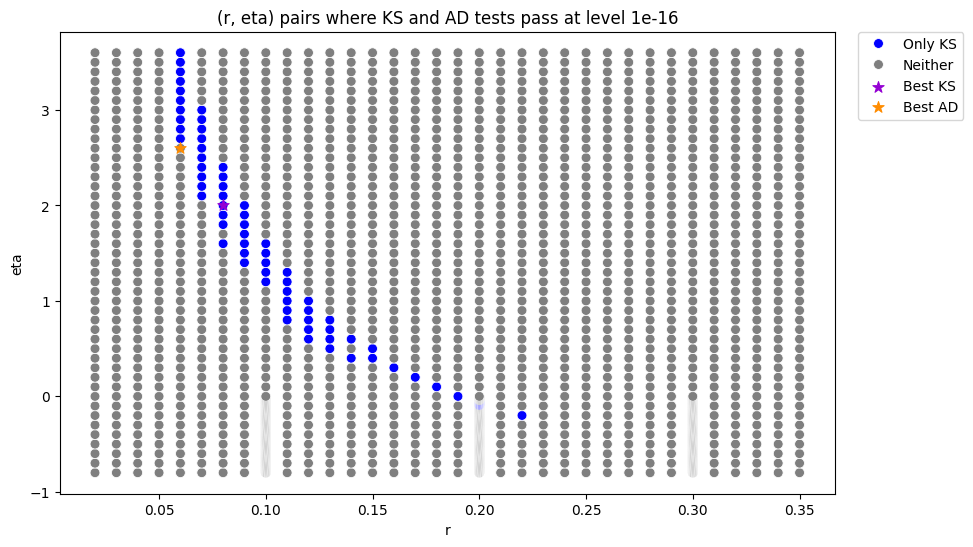

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    fine_stats_df,
    x='r',
    y='eta',
    s=50,
    hue='pass_summary',
    palette={
        'Both': 'green',
        'Only KS': 'blue',
        'Only AD': 'gold',
        'Neither': 'tab:gray'
    }
)
sns.scatterplot(x=[ks_argmin_row['r']], y=[ks_argmin_row['eta']], marker='*', s=75, c='darkviolet', edgecolor=None, label='Best KS')
sns.scatterplot(x=[ad_argmin_row['r']], y=[ad_argmin_row['eta']], marker='*', s=75, c='darkorange', edgecolor=None, label='Best AD')

handles, labels = plt.gca().get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))
ordered_labels = list(filter(label_to_handle.__contains__, ['Both', 'Only KS', 'Only AD', 'Neither', 'Best KS', 'Best AD']))
ordered_handles = [label_to_handle[label] for label in ordered_labels]
plt.legend(ordered_handles, ordered_labels, bbox_to_anchor=(1.175, 1.015), loc='upper right')

alpha = alpha_ks if alpha_ks == alpha_ad else f'{(alpha_ks, alpha_ad)}, respectively'
plt.title(f'(r, eta) pairs where KS and AD tests pass at level {alpha}')
plt.show()